This kernel is modified from [the one Yassine Ghouzam shared](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6), with tensorflow 2.0 and GPU computation.

In [31]:
import itertools, os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt, image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

sns.set()

GPU configuration

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Data Preparation

In [3]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [4]:
y = train.label
X = train.drop(columns='label')

del train

In [5]:
X.shape

(42000, 784)

In [6]:
test.shape

(28000, 784)

## Check for missing values

In [7]:
X.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## Normalization

Use ImageDataGenerator for normalization.

In [9]:
# X.max(axis=1).min()

In [10]:
# test.max(axis=1).min()

In [11]:
# X_norm = X / 255
# test_norm = test / 255

## Reshape

In [12]:
np.sqrt(X.columns.size)

28.0

The image size is $28 \times 28$, single channel.

In [13]:
# X_img = X_norm.values.reshape(-1,28,28,1)
# test_img = test_norm.values.reshape(-1,28,28,1)
X_img = X.values.reshape(-1,28,28,1)
test_img = test.values.reshape(-1,28,28,1)

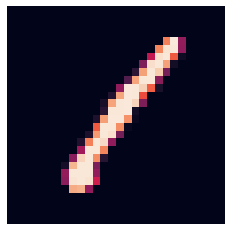

In [14]:
plt.axis('off')
plt.imshow(X_img[0,:,:,0])
plt.show()

## Label encoding

In [15]:
y_one_hot = pd.get_dummies(y)

In [16]:
y_one_hot.head()

0  1  2  3  4  5  6  7  8  9
0  0  1  0  0  0  0  0  0  0  0
1  1  0  0  0  0  0  0  0  0  0
2  0  1  0  0  0  0  0  0  0  0
3  0  0  0  0  1  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_img, y_one_hot, test_size=0.1)

## Data Augmentation

In [18]:
train_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=True,
    featurewise_std_normalization=False,
    samplewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

test_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)

Here, I use two data generators since the images in the validation set and the test set do not require augmentation other than normalization.

Also, fitting the generator is not required if there's no featurewise normalization and ZCA whitening.

# Model

In [19]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same',
                 activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',
                 activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()
#plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Annealing

In [21]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=3,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=1e-5)

# Training

In [22]:
print(f'Number of samples: {X_train.shape[0]}')

Number of samples: 37800


In [23]:
batch_size = 32
epochs = 30
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=test_datagen.flow(X_val, y_val, batch_size=batch_size),
    verbose=2,
    callbacks=[lr_reduction])

Epoch 1/30
1182/1182 - 44s - loss: 0.3236 - accuracy: 0.8975 - val_loss: 0.0590 - val_accuracy: 0.9833
Epoch 2/30
1182/1182 - 43s - loss: 0.1247 - accuracy: 0.9634 - val_loss: 0.0453 - val_accuracy: 0.9857
Epoch 3/30
1182/1182 - 43s - loss: 0.0962 - accuracy: 0.9718 - val_loss: 0.0345 - val_accuracy: 0.9895
Epoch 4/30
1182/1182 - 43s - loss: 0.0840 - accuracy: 0.9750 - val_loss: 0.0433 - val_accuracy: 0.9883
Epoch 5/30
1182/1182 - 42s - loss: 0.0778 - accuracy: 0.9767 - val_loss: 0.0399 - val_accuracy: 0.9890
Epoch 6/30
1182/1182 - 42s - loss: 0.0718 - accuracy: 0.9801 - val_loss: 0.0322 - val_accuracy: 0.9910
Epoch 7/30
1182/1182 - 41s - loss: 0.0680 - accuracy: 0.9801 - val_loss: 0.0288 - val_accuracy: 0.9910
Epoch 8/30
1182/1182 - 41s - loss: 0.0638 - accuracy: 0.9819 - val_loss: 0.0238 - val_accuracy: 0.9926
Epoch 9/30
1182/1182 - 40s - loss: 0.0617 - accuracy: 0.9814 - val_loss: 0.0288 - val_accuracy: 0.9914
Epoch 10/30
1182/1182 - 41s - loss: 0.0608 - accuracy: 0.9824 - val_loss:

# Evaluation

First, I generated predictions of the validation set for later use.

In [24]:
y_pred_prob = model.predict_generator(test_datagen.flow(X_val, shuffle=False))
y_pred = y_pred_prob.argmax(1)
y_true = y.loc[y_val.index]

## Accuracy

Text(0.5, 1.0, 'Accuracy')

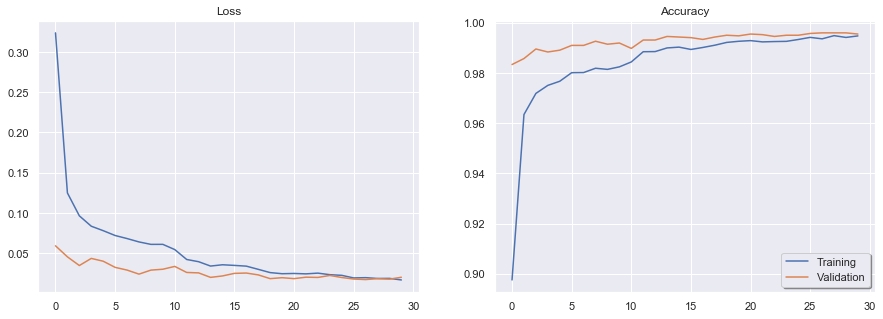

In [25]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

ax = axes[0]
ax.plot(history.history['loss'], label='Training')
ax.plot(history.history['val_loss'], label='Validation')
ax.set_title('Loss')

ax = axes[1]
ax.plot(history.history['accuracy'], label='Training')
ax.plot(history.history['val_accuracy'], label='Validation')
ax.legend(loc=4, shadow=True)
ax.set_title('Accuracy')

## Confusion Matrix

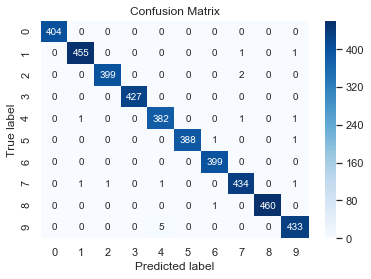

In [26]:
c_mat = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(c_mat, columns=range(10), index=range(10))
df_cm.index.name = 'True label'
df_cm.columns.name = 'Predicted label'
sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='d')
plt.ylim(10,0) # Due to matplotlib updates, this has to be specified manually.
plt.title('Confusion Matrix')
plt.show()

# Submission

In [27]:
output_prob = model.predict_generator(test_datagen.flow(test_img, shuffle=False))

In [28]:
output = pd.DataFrame(data=zip(range(1,output_prob.shape[0]+1),output_prob.argmax(1)),
                      columns=['ImageId','Label'])
output.head()

ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3

In [32]:
if not os.path.exists('../output/'):
    os.makedirs('../output/')
output.to_csv('../output/output.csv',index=False)